In [31]:
#imports
import pandas as pd
import tensorflow
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from keras.models import Sequential, load_model
from keras import layers as l
from keras.metrics import AUC
from keras.callbacks import EarlyStopping
from keras.optimizer_v2.adam import Adam
import matplotlib.pyplot as plt

In [32]:
#get features/labels
data = pd.read_csv('cover_data.csv')
features = data.drop(['class'], axis=1)
features.head()
labels = data['class']

#split features and labels
ftr, fte, ltr, lte = train_test_split(features, labels, test_size=.25)

#scale features
fcols = features.columns
ct = ColumnTransformer([('only numeric', MinMaxScaler(), fcols)], remainder='passthrough')
sftr = ct.fit_transform(ftr)
sfte = ct.fit_transform(fte)

#scale labels
sltr = tensorflow.keras.utils.to_categorical(ltr, dtype='int64')
slte = tensorflow.keras.utils.to_categorical(lte, dtype='int64')

In [42]:
#create model
def make_model():
    model = Sequential()
    model.add(l.InputLayer(input_shape=sftr.shape[1],))
    model.add(l.Dense(128, activation='relu'))
    # model.add(l.Dropout(.1))
    model.add(l.Dense(128, activation='relu'))
    model.add(l.Dropout(.085))
    model.add(l.Dense(64, activation='relu'))
    # model.add(l.Dropout(.05))
    model.add(l.Dense(64, activation='relu'))
    # model.add(l.Dropout(.1))
    model.add(l.Dense(8, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate= .0019), metrics=['accuracy'])
    print(model.summary())
    return model

model = make_model()
# model = load_model('saves/sequential')

Model: "mom"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 128)               7040      
                                                                 
 dense_11 (Dense)            (None, 128)               16512     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_12 (Dense)            (None, 64)                8256      
                                                                 
 dense_13 (Dense)            (None, 64)                4160      
                                                                 
 dense_14 (Dense)            (None, 8)                 520       
                                                                 
Total params: 36,488
Trainable params: 36,488
Non-trainable par

In [43]:
#fit model
es = EarlyStopping(monitor='val_accuracy', mode='max', patience=20, verbose=1)
history = model.fit(sftr, sltr, batch_size=175, epochs=300, verbose=1, validation_split=.2, callbacks=[es])

Epoch 1/300
1993/1993 [==============================] - 11s 5ms/step - loss: 0.6215 - accuracy: 0.7321 - val_loss: 0.6004 - val_accuracy: 0.7286
Epoch 2/300
1993/1993 [==============================] - 10s 5ms/step - loss: 0.5096 - accuracy: 0.7793 - val_loss: 0.4744 - val_accuracy: 0.7956
Epoch 3/300
1993/1993 [==============================] - 11s 5ms/step - loss: 0.4544 - accuracy: 0.8052 - val_loss: 0.4580 - val_accuracy: 0.8013
Epoch 4/300
1993/1993 [==============================] - 12s 6ms/step - loss: 0.4186 - accuracy: 0.8211 - val_loss: 0.3907 - val_accuracy: 0.8351
Epoch 5/300
1993/1993 [==============================] - 19s 9ms/step - loss: 0.3931 - accuracy: 0.8336 - val_loss: 0.3751 - val_accuracy: 0.8423
Epoch 6/300
1993/1993 [==============================] - 11s 5ms/step - loss: 0.3727 - accuracy: 0.8431 - val_loss: 0.3562 - val_accuracy: 0.8505
Epoch 7/300
1993/1993 [==============================] - 9s 5ms/step - loss: 0.3560 - accuracy: 0.8503 - val_loss: 0.3405 - 

Text(0, 0.5, 'accuracy')

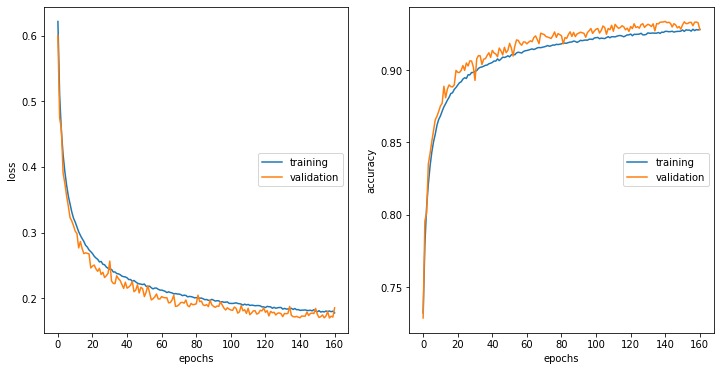

In [44]:
#pretty graphs :O
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(1,2,1)
ax1.plot(history.history['loss'], label='training')
ax1.plot(history.history['val_loss'], label='validation')
ax1.legend(loc='center right')
ax1.set_xlabel('epochs')
ax1.set_ylabel('loss')

ax2 = fig.add_subplot(1,2,2)
ax2.plot(history.history['accuracy'], label='training')
ax2.plot(history.history['val_accuracy'], label='validation')
ax2.legend(loc='center right')
ax2.set_xlabel('epochs')
ax2.set_ylabel('accuracy')


In [45]:
#Estimates vs True
y_est = model.predict(sfte)
y_est = np.argmax(y_est, axis=1)
y_true = np.argmax(slte, axis=1)

In [46]:
print(classification_report(y_true, y_est))

              precision    recall  f1-score   support

           1       0.96      0.89      0.92     52852
           2       0.92      0.96      0.94     70924
           3       0.92      0.95      0.94      8981
           4       0.83      0.88      0.85       716
           5       0.80      0.78      0.79      2385
           6       0.89      0.86      0.88      4307
           7       0.90      0.96      0.93      5088

    accuracy                           0.93    145253
   macro avg       0.89      0.90      0.89    145253
weighted avg       0.93      0.93      0.93    145253



In [47]:
cm = confusion_matrix(y_true, y_est)
print(cm)

[[47202  5106     2     0    53    11   478]
 [ 1965 68166   182     1   400   171    39]
 [    0   149  8517    86     5   224     0]
 [    0     0    70   627     0    19     0]
 [   48   410    42     0  1870    15     0]
 [    0   147   412    39     3  3706     0]
 [  155    57     0     0     1     0  4875]]


In [48]:
model.save(f'saves/{model.name}')
print(f'saved {model.name} to saves')

INFO:tensorflow:Assets written to: saves/mom/assets
saved mom to saves
